In [1]:
import time
start_time = time.time()

# Preparation - Data grouped on forum level

Import the packages and load the data

In [2]:
# Import needed READkages
import os
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import KBinsDiscretizer
import seaborn as sns; sns.set()
import glob
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols
import re
import nltk
from langdetect import detect
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
from lime import lime_text
import gensim
import gensim.downloader as gensim_api
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
import transformers
plt.style.use('seaborn-whitegrid')
sns.set_style("whitegrid")
from bs4 import BeautifulSoup
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import EnglishStemmer
import spacy
from spacy import displacy
from wordcloud import WordCloud
from sklearn.preprocessing import KBinsDiscretizer
from nbpep8.nbpep8 import pep8
from sklearn.metrics.pairwise import cosine_similarity
from linearmodels import PanelOLS
from linearmodels.panel import PanelOLS
from linearmodels.panel import PooledOLS
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan

In [3]:
#Set the working directory
os.chdir('C:\\Users\\piotr\\OneDrive - Erasmus University Rotterdam\\Thesis\\')

In [4]:
#Load the results of the content novelty calculation, that were saved as follows:
final_result_df_tfidf = pd.read_csv('Master Thesis Data\\final_result_df_tfidf.csv')
final_result_df_lsi = pd.read_csv('Master Thesis Data\\final_result_df_lsi.csv')
final_result_df_doc2vec = pd.read_csv('Master Thesis Data\\final_result_df_doc2vec.csv')

Load the grouped data frames

In [5]:
#Load the estimation data frames
est_grouped_df_week = pd.read_csv('Master Thesis Data\\estimation_dfs\\est_grouped_df_week.csv')
est_grouped_df_week_tag = pd.read_csv('Master Thesis Data\\estimation_dfs\\est_grouped_df_week_tag.csv')
est_grouped_df_week_tag_reduced = pd.read_csv('Master Thesis Data\\estimation_dfs\\est_grouped_df_week_tag_reduced.csv')

Drop the weeks (Week_of_Year) 17 and 26 from all dfs

In [6]:
##Drop the weeks (Week_of_Year) 17 and 26 from all dfs, as they are incomplete
est_grouped_df_week = est_grouped_df_week[est_grouped_df_week['Week_of_Year'] != 17]
est_grouped_df_week = est_grouped_df_week[est_grouped_df_week['Week_of_Year'] != 26]
est_grouped_df_week_tag = est_grouped_df_week_tag[est_grouped_df_week_tag['Week_of_Year'] != 17]
est_grouped_df_week_tag = est_grouped_df_week_tag[est_grouped_df_week_tag['Week_of_Year'] != 26]
est_grouped_df_week_tag_reduced = est_grouped_df_week_tag_reduced[est_grouped_df_week_tag_reduced['Week_of_Year'] != 17]
est_grouped_df_week_tag_reduced = est_grouped_df_week_tag_reduced[est_grouped_df_week_tag_reduced['Week_of_Year'] != 26]

In [7]:
est_grouped_df_week_tag_reduced.head(5)

,tag_combined,Post_Creation_Date,Post_Count,Post_Answer_Count,ari,fre,fk_grade,gunning_fog,D,T,...,Post_View_Count,Post_Score,Response_Scores,Post_Author,Answer_Author,Title_Length,Body_Length,Week_Start_Date,Week_Number,DiD
1,.htaccessapache,2021-07-05/2021-07-11,8,6,9.875000,67.343750,8.7625,10.328750,0.0,0.0,...,1187,11,9,8,3,55.25,1004.500000,2021-07-05,2,0.0
2,.htaccessapache,2021-07-12/2021-07-18,6,5,9.833333,65.216667,7.7500,7.706667,0.0,0.0,...,2590,7,12,6,4,66.00,1780.166667,2021-07-12,3,0.0
3,.htaccessapache,2021-07-19/2021-07-25,5,4,10.720000,61.534000,8.7600,9.546000,0.0,0.0,...,1115,5,4,5,5,73.00,2025.200000,2021-07-19,4,0.0
4,.htaccessapache,2021-07-26/2021-08-01,8,7,8.075000,70.766250,6.6750,7.420000,0.0,0.0,...,1427,7,14,8,2,56.00,1571.125000,2021-07-26,5,0.0
5,.htaccessapache,2021-08-02/2021-08-08,5,4,9.080000,68.550000,7.7200,8.926000,0.0,0.0,...,902,2,2,5,2,48.80,1315.600000,2021-08-02,6,0.0


## Average the readability metrics

Columns with different redability metrics:

ari	

fre	 (1-fre)

fk_grade

gunning_fog

smog_index	

coleman_liau_index

In [8]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Instantiate the scaler
scaler = MinMaxScaler()

# List of columns to normalize
cols_to_normalize = ['ari', 'fre', 'fk_grade', 'gunning_fog', 'smog_index', 'coleman_liau_index']

# List of DataFrames
dfs = [est_grouped_df_week, est_grouped_df_week_tag, est_grouped_df_week_tag_reduced]

# Apply normalization and averaging to each DataFrame
for df in dfs:
    # Apply the scaler to the DataFrame
    df[cols_to_normalize] = scaler.fit_transform(df[cols_to_normalize])

    # Invert the 'fre' column
    df['fre'] = 1 - df['fre']

    # Add a new column with the average of the normalized columns
    df['avg_readability'] = df[cols_to_normalize].mean(axis=1)


# Choose the data frame

Note that the data ranges from 01-07-2021 to 30-04-2022 and from 01-07-2022 to 30-04-2023. That implies that the weeks 18,19,20,21,22,23,24,25 are not present in the data set.
Weeks 17 and 26 are dropped as they are incomplete

# 8.1 PTA - tag reduced level

## 8.1.1 Post Counts

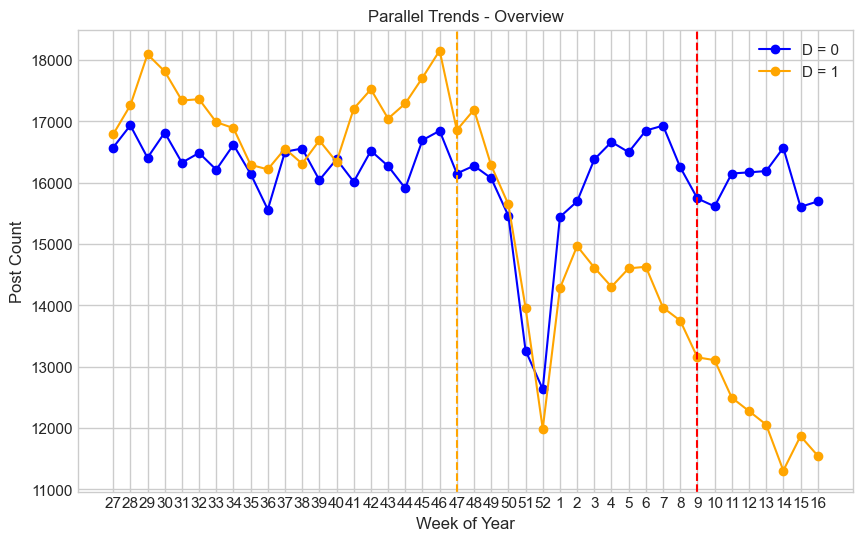

C:\Users\piotr\AppData\Local\Temp\ipykernel_21508\2502604590.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Week_of_Year_{i}_D'] = df[f'Week_of_Year_{i}'] * df['D']
C:\Users\piotr\AppData\Local\Temp\ipykernel_21508\2502604590.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Week_of_Year_{i}'] = np.where(df['Week_of_Year'] == i, 1, 0)
C:\Users\piotr\AppData\Local\Temp\ipykernel_21508\2502604590.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

                          PanelOLS Estimation Summary                           
Dep. Variable:             Post_Count   R-squared:                        0.0266
Estimator:                   PanelOLS   R-squared (Between):              0.0000
No. Observations:               47208   R-squared (Within):               0.0481
Date:                Sat, May 27 2023   R-squared (Overall):              0.0017
Time:                        13:12:06   Log-likelihood                -1.792e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      31.043
Entities:                         562   P-value                           0.0000
Avg Obs:                       84.000   Distribution:                F(41,46564)
Min Obs:                       84.000                                           
Max Obs:                       84.000   F-statistic (robust):             3.7801
                            

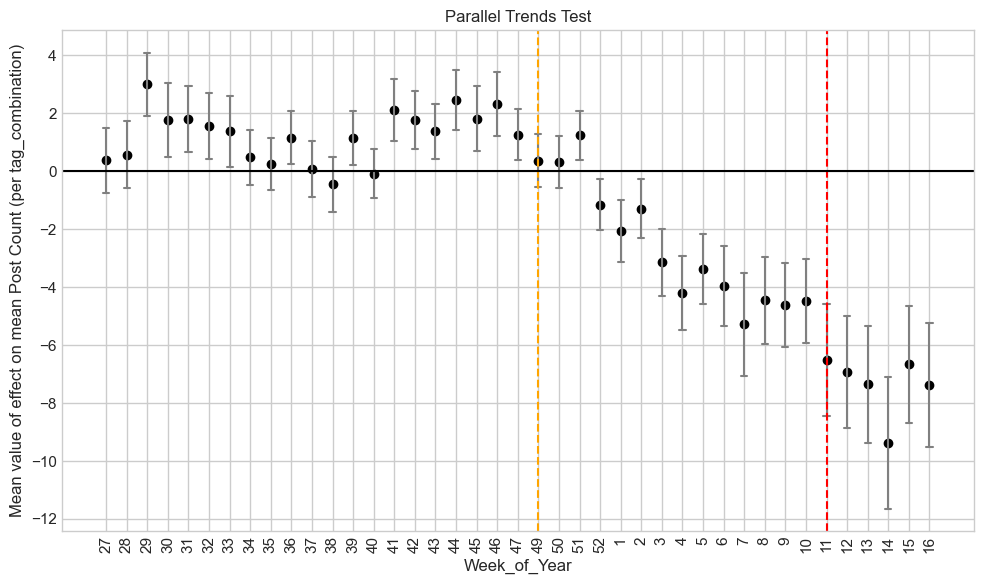

In [41]:
df = est_grouped_df_week_tag_reduced.copy()

# Create separate dataframes for D=0 and D=1
df_D0 = df[df['D'] == 0]
df_D1 = df[df['D'] == 1]

# Group by 'Week_of_Year' and calculate the sum 'Post_Count'
df_D0_grouped = df_D0.groupby('Week_of_Year')['Post_Count'].sum()
df_D1_grouped = df_D1.groupby('Week_of_Year')['Post_Count'].sum()

# Separate the weeks into two halves
first_half_D0 = df_D0_grouped[df_D0_grouped.index >= 27]
second_half_D0 = df_D0_grouped[df_D0_grouped.index < 27]
df_D0_grouped = pd.concat([first_half_D0, second_half_D0])

first_half_D1 = df_D1_grouped[df_D1_grouped.index >= 27]
second_half_D1 = df_D1_grouped[df_D1_grouped.index < 27]
df_D1_grouped = pd.concat([first_half_D1, second_half_D1])

# Create a new sequence of numbers for x-axis representing the actual order of weeks.
new_x = np.arange(1, len(df_D0_grouped) + 1)

# Plot the post counts for each group as lines with points
plt.figure(figsize=(10, 6))
plt.plot(new_x, df_D0_grouped.values, marker='o', color='blue', label='D = 0')
plt.plot(new_x, df_D1_grouped.values, marker='o', color='orange', label='D = 1')

# Add legend
plt.legend()

plt.title("Parallel Trends - Overview")
plt.xlabel("Week of Year")
plt.ylabel("Post Count")
plt.grid(True)


# Add dashed orange line for week 49
plt.axvline(21, color='orange', linestyle='--')

# Add dashed red line for week 11
plt.axvline(35, color='red', linestyle='--')

# Show actual weeks on x-axis
plt.xticks(ticks=new_x, labels=df_D0_grouped.index)

plt.show()

#Drop Week_Number
df = df.drop(['Week_Number'], axis=1)


# Generate the dummy variables for the periods
for i in range(1, 53):
    if i != 0 and i != 48:  # Exclude Week_of_Year 48 (dummy trap)
        df[f'Week_of_Year_{i}'] = np.where(df['Week_of_Year'] == i, 1, 0)
        df[f'Week_of_Year_{i}_D'] = df[f'Week_of_Year_{i}'] * df['D']


# Set the index for the panel data
df = df.set_index(['tag_combined', 'Week_of_Year'])

# Create exogenous variables and add a constant
# Create exogenous variables and add a constant
exog_vars = [f'Week_of_Year_{i}_D' for i in range(1, 53) if i != 0 and i != 48]  # Exclude Week_of_Year == 48 (dummy trap)
exog = sm.add_constant(df[exog_vars])


# Run the regression
mod = PanelOLS(df.Post_Count, exog, entity_effects=True, check_rank=False, drop_absorbed=True, time_effects=True)
fe_res = mod.fit(cov_type='clustered', cluster_entity=True)



# Print the result
print(fe_res)


# Extract parameters and t-statistics from fe_res
params = fe_res.params[1:]  # Exclude constant
tvalues = fe_res.tstats[1:]  # Exclude constant

# Calculate standard errors: sqrt of variance
stderr = np.sqrt(np.diag(fe_res.cov))[1:]  # Exclude constant

# Calculate p-values
pvalues = fe_res.pvalues[1:]  # Exclude constant

# Create a new DataFrame from these values
results_df = pd.DataFrame({"params": params, "stderr": stderr, "tvalues": tvalues, "pvalues": pvalues})

# Add 'Week_of_Year' values as a column
# As per your input, these range from 1 to 16 and 27 to 47, 49 to 52
week_of_year_values = list(range(1, 17)) + list(range(27, 48)) + list(range(49, 53))
results_df["Week_of_Year"] = week_of_year_values

# Calculate lower and upper CI (assuming normal distribution)
results_df["lower_ci"] = results_df["params"] - 1.96*results_df["stderr"]
results_df["upper_ci"] = results_df["params"] + 1.96*results_df["stderr"]

# Create a custom order for 'Week_of_Year' - from 27 to 52, and then from 1 to 16
order = list(range(27, 48)) + list(range(49, 53)) + list(range(1, 17))

# Create a mapping of week numbers to new ordered indices
week_to_idx = {week: idx for idx, week in enumerate(order)}

# Map 'Week_of_Year' to the new ordered indices
results_df['Week_of_Year_Idx'] = results_df['Week_of_Year'].map(week_to_idx)

# Sort by the new index
results_df.sort_values("Week_of_Year_Idx", inplace=True)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the parameters as black scatter points
plt.scatter(results_df['Week_of_Year_Idx'], results_df['params'], color='black')

# Add vertical 'boxes' for each 'Week_of_Year'
for _, row in results_df.iterrows():
    plt.plot([row['Week_of_Year_Idx'], row['Week_of_Year_Idx']], [row['lower_ci'], row['upper_ci']], color="gray")

# Add short orthogonal lines at the top and bottom of each box
box_width = 0.3  # Adjust as needed
for _, row in results_df.iterrows():
    plt.plot([row['Week_of_Year_Idx'] - box_width/2, row['Week_of_Year_Idx'] + box_width/2], [row['lower_ci'], row['lower_ci']], color="gray")
    plt.plot([row['Week_of_Year_Idx'] - box_width/2, row['Week_of_Year_Idx'] + box_width/2], [row['upper_ci'], row['upper_ci']], color="gray")


# Add dashed orange line for week 49
plt.axvline(21, color='orange', linestyle='--')

# Add dashed red line for week 11
plt.axvline(35, color='red', linestyle='--')

# Add firm blue line for value 0 on y-axis
plt.axhline(0, color='black', linestyle='-')



# Adjust x-axis to display actual week numbers
plt.xticks(results_df['Week_of_Year_Idx'], results_df['Week_of_Year'], rotation='vertical')

plt.title("Parallel Trends Test")
plt.xlabel("Week_of_Year")
plt.ylabel("Mean value of effect on mean Post Count (per tag_combination)")

plt.tight_layout()
plt.show()


## 8.1.2 Post_View_Count

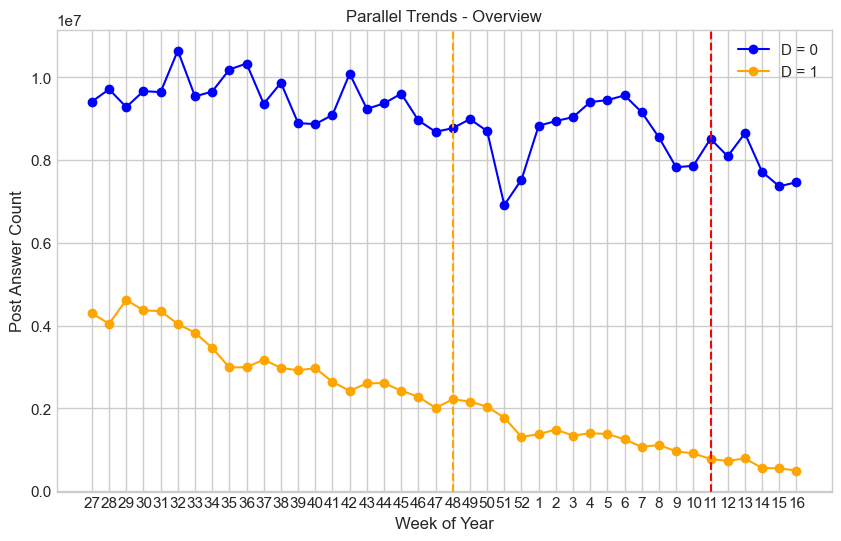

C:\Users\piotr\AppData\Local\Temp\ipykernel_21508\3972841438.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Week_of_Year_{i}_D'] = df[f'Week_of_Year_{i}'] * df['D']
C:\Users\piotr\AppData\Local\Temp\ipykernel_21508\3972841438.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Week_of_Year_{i}'] = np.where(df['Week_of_Year'] == i, 1, 0)
C:\Users\piotr\AppData\Local\Temp\ipykernel_21508\3972841438.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

                          PanelOLS Estimation Summary                           
Dep. Variable:        Post_View_Count   R-squared:                        0.0777
Estimator:                   PanelOLS   R-squared (Between):              0.0000
No. Observations:               47208   R-squared (Within):               0.0765
Date:                Sat, May 27 2023   R-squared (Overall):              0.0376
Time:                        13:14:40   Log-likelihood                 -5.36e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      95.711
Entities:                         562   P-value                           0.0000
Avg Obs:                       84.000   Distribution:                F(41,46564)
Min Obs:                       84.000                                           
Max Obs:                       84.000   F-statistic (robust):             4.8088
                            

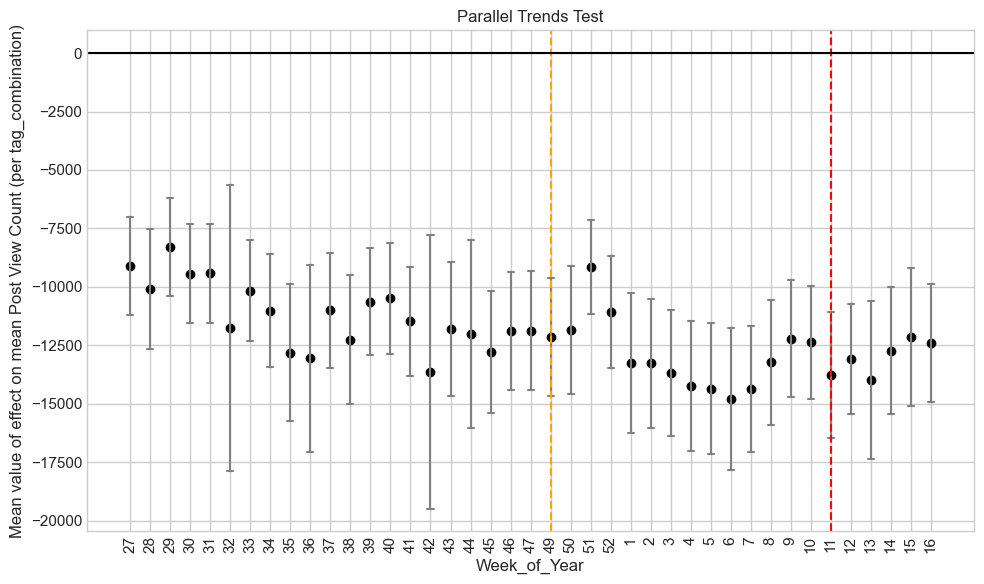

In [42]:
df = est_grouped_df_week_tag_reduced.copy()

# Create separate dataframes for D=0 and D=1
df_D0_PVC = df[df['D'] == 0]
df_D1_PVC = df[df['D'] == 1]

# Group by 'Week_of_Year' and calculate the sum 'Post_Count'
df_D0_grouped_PVC = df_D0_PVC.groupby('Week_of_Year')['Post_Score'].sum()
df_D1_grouped_PVC = df_D1_PVC.groupby('Week_of_Year')['Post_Score'].sum()

# Separate the weeks into two halves
first_half_D0_PVC = df_D0_grouped_PVC[df_D0_grouped_PVC.index >= 27]
second_half_D0_PVC = df_D0_grouped_PVC[df_D0_grouped_PVC.index < 27]
df_D0_grouped_PVC = pd.concat([first_half_D0_PVC, second_half_D0_PVC])

first_half_D1_PVC = df_D1_grouped_PVC[df_D1_grouped_PVC.index >= 27]
second_half_D1_PVC = df_D1_grouped_PVC[df_D1_grouped_PVC.index < 27]
df_D1_grouped_PVC = pd.concat([first_half_D1_PVC, second_half_D1_PVC])

# Create a new sequence of numbers for x-axis representing the actual order of weeks.
new_x = np.arange(1, len(df_D0_grouped_PVC) + 1)

# Plot the post counts for each group as lines with points
plt.figure(figsize=(10, 6))
plt.plot(new_x, df_D0_grouped_PVC.values, marker='o', color='blue', label='D = 0')
plt.plot(new_x, df_D1_grouped_PVC.values, marker='o', color='orange', label='D = 1')

# Add legend
plt.legend()

plt.title("Parallel Trends - Overview")
plt.xlabel("Week of Year")
plt.ylabel("Post Answer Count")
plt.grid(True)


# Add dashed orange line for week 49
plt.axvline(22, color='orange', linestyle='--')

# Add dashed red line for week 11
plt.axvline(37, color='red', linestyle='--')

# Show actual weeks on x-axis
plt.xticks(ticks=new_x, labels=df_D0_grouped.index)

plt.show()


#Drop Week_Number
df = df.drop(['Week_Number'], axis=1)


# Generate the dummy variables for the periods
for i in range(1, 53):
    if i != 0 and i != 48:  # Exclude Week_of_Year 48 (dummy trap)
        df[f'Week_of_Year_{i}'] = np.where(df['Week_of_Year'] == i, 1, 0)
        df[f'Week_of_Year_{i}_D'] = df[f'Week_of_Year_{i}'] * df['D']


# Set the index for the panel data
df = df.set_index(['tag_combined', 'Week_of_Year'])

# Create exogenous variables and add a constant
# Create exogenous variables and add a constant
exog_vars = [f'Week_of_Year_{i}_D' for i in range(1, 53) if i != 0 and i != 48]  # Exclude Week_of_Year == 48 (dummy trap)
exog = sm.add_constant(df[exog_vars])


# Run the regression
mod_PVC = PanelOLS(df.Post_View_Count, exog, entity_effects=True, check_rank=False, drop_absorbed=True, time_effects=True)
fe_res_PVC = mod_PVC.fit(cov_type='clustered', cluster_entity=True)



# Print the result
print(fe_res_PVC)

# Extract parameters and t-statistics from fe_res
params_PVC = fe_res_PVC.params[1:]  # Exclude constant
tvalues_PVC = fe_res_PVC.tstats[1:]  # Exclude constant

# Calculate standard errors: sqrt of variance
stderr_PVC = np.sqrt(np.diag(fe_res_PVC.cov))[1:]  # Exclude constant

# Calculate p-values
pvalues_PVC = fe_res_PVC.pvalues[1:]  # Exclude constant

# Create a new DataFrame from these values
results_df_PVC = pd.DataFrame({"params": params_PVC, "stderr": stderr_PVC, "tvalues": tvalues_PVC, "pvalues": pvalues_PVC})

# Add 'Week_of_Year' values as a column
# As per your input, these range from 1 to 16 and 27 to 47, 49 to 52
week_of_year_values = list(range(1, 17)) + list(range(27, 48)) + list(range(49, 53))
results_df_PVC["Week_of_Year"] = week_of_year_values

# Calculate lower and upper CI (assuming normal distribution)
results_df_PVC["lower_ci"] = results_df_PVC["params"] - 1.96*results_df_PVC["stderr"]
results_df_PVC["upper_ci"] = results_df_PVC["params"] + 1.96*results_df_PVC["stderr"]

# Create a custom order for 'Week_of_Year' - from 27 to 52, and then from 1 to 16
order = list(range(27, 48)) + list(range(49, 53)) + list(range(1, 17))

# Create a mapping of week numbers to new ordered indices
week_to_idx = {week: idx for idx, week in enumerate(order)}

# Map 'Week_of_Year' to the new ordered indices
results_df_PVC['Week_of_Year_Idx'] = results_df_PVC['Week_of_Year'].map(week_to_idx)

# Sort by the new index
results_df_PVC.sort_values("Week_of_Year_Idx", inplace=True)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the parameters as black scatter points
plt.scatter(results_df_PVC['Week_of_Year_Idx'], results_df_PVC['params'], color='black')

# Add vertical 'boxes' for each 'Week_of_Year'
for _, row in results_df_PVC.iterrows():
    plt.plot([row['Week_of_Year_Idx'], row['Week_of_Year_Idx']], [row['lower_ci'], row['upper_ci']], color="gray")

# Add short orthogonal lines at the top and bottom of each box
box_width = 0.3  # Adjust as needed
for _, row in results_df_PVC.iterrows():
    plt.plot([row['Week_of_Year_Idx'] - box_width/2, row['Week_of_Year_Idx'] + box_width/2], [row['lower_ci'], row['lower_ci']], color="gray")
    plt.plot([row['Week_of_Year_Idx'] - box_width/2, row['Week_of_Year_Idx'] + box_width/2], [row['upper_ci'], row['upper_ci']], color="gray")


# Add dashed orange line for week 49
plt.axvline(21, color='orange', linestyle='--')

# Add dashed red line for week 11
plt.axvline(35, color='red', linestyle='--')

# Add firm blue line for value 0 on y-axis
plt.axhline(0, color='black', linestyle='-')



# Adjust x-axis to display actual week numbers
plt.xticks(results_df_PVC['Week_of_Year_Idx'], results_df_PVC['Week_of_Year'], rotation='vertical')

plt.title("Parallel Trends Test")
plt.xlabel("Week_of_Year")
plt.ylabel("Mean value of effect on mean Post View Count (per tag_combination)")

plt.tight_layout()
plt.show()



## 8.1.3 Post_Score

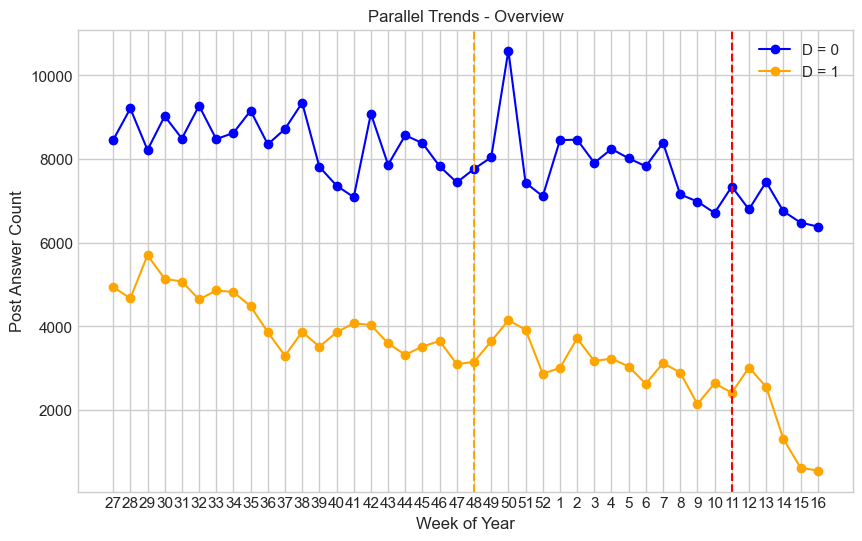

C:\Users\piotr\AppData\Local\Temp\ipykernel_21508\3550472982.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Week_of_Year_{i}_D'] = df[f'Week_of_Year_{i}'] * df['D']
C:\Users\piotr\AppData\Local\Temp\ipykernel_21508\3550472982.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Week_of_Year_{i}'] = np.where(df['Week_of_Year'] == i, 1, 0)
C:\Users\piotr\AppData\Local\Temp\ipykernel_21508\3550472982.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

                          PanelOLS Estimation Summary                           
Dep. Variable:             Post_Score   R-squared:                        0.0489
Estimator:                   PanelOLS   R-squared (Between):            2.22e-16
No. Observations:               47208   R-squared (Within):               0.0475
Date:                Sat, May 27 2023   R-squared (Overall):              0.0178
Time:                        14:00:25   Log-likelihood                -2.033e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      58.355
Entities:                         562   P-value                           0.0000
Avg Obs:                       84.000   Distribution:                F(41,46564)
Min Obs:                       84.000                                           
Max Obs:                       84.000   F-statistic (robust):             5.6206
                            

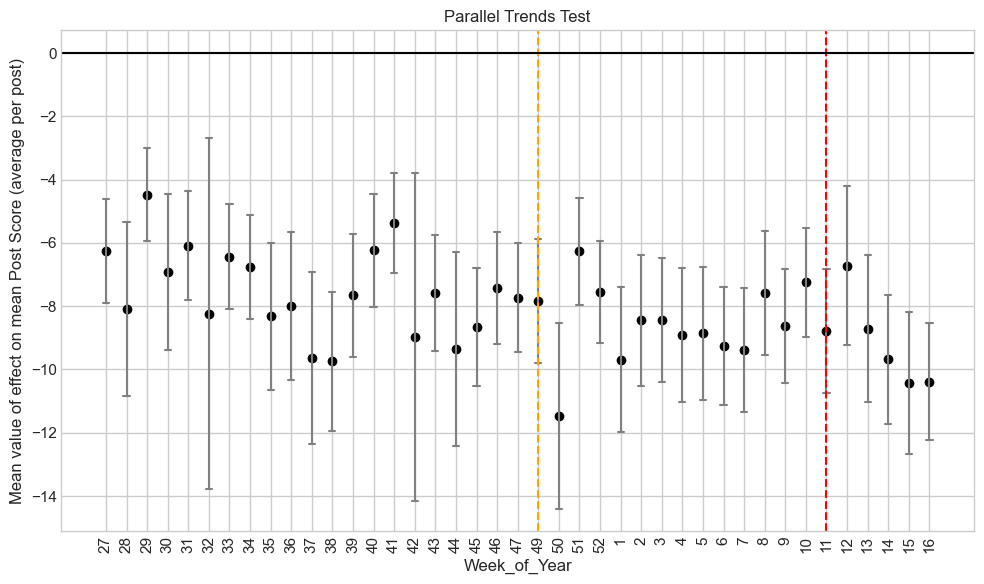

In [81]:
df = est_grouped_df_week_tag_reduced.copy()

# Create separate dataframes for D=0 and D=1
df_D0_PS = df[df['D'] == 0]
df_D1_PS = df[df['D'] == 1]

# Group by 'Week_of_Year' and calculate the sum 'Post_Count'
df_D0_grouped_PS = df_D0_PS.groupby('Week_of_Year')['Post_Score'].sum()
df_D1_grouped_PS = df_D1_PS.groupby('Week_of_Year')['Post_Score'].sum()

# Separate the weeks into two halves
first_half_D0_PS = df_D0_grouped_PS[df_D0_grouped_PS.index >= 27]
second_half_D0_PS = df_D0_grouped_PS[df_D0_grouped_PS.index < 27]
df_D0_grouped_PS = pd.concat([first_half_D0_PS, second_half_D0_PS])

first_half_D1_PS = df_D1_grouped_PS[df_D1_grouped_PS.index >= 27]
second_half_D1_PS = df_D1_grouped_PS[df_D1_grouped_PS.index < 27]
df_D1_grouped_PS = pd.concat([first_half_D1_PS, second_half_D1_PS])

# Create a new sequence of numbers for x-axis representing the actual order of weeks.
new_x = np.arange(1, len(df_D0_grouped_PS) + 1)

# Plot the post counts for each group as lines with points
plt.figure(figsize=(10, 6))
plt.plot(new_x, df_D0_grouped_PS.values, marker='o', color='blue', label='D = 0')
plt.plot(new_x, df_D1_grouped_PS.values, marker='o', color='orange', label='D = 1')

# Add legend
plt.legend()

plt.title("Parallel Trends - Overview")
plt.xlabel("Week of Year")
plt.ylabel("Post Answer Count")
plt.grid(True)


# Add dashed orange line for week 49
plt.axvline(22, color='orange', linestyle='--')

# Add dashed red line for week 11
plt.axvline(37, color='red', linestyle='--')

# Show actual weeks on x-axis
plt.xticks(ticks=new_x, labels=df_D0_grouped.index)

plt.show()


#Drop Week_Number
df = df.drop(['Week_Number'], axis=1)


# Generate the dummy variables for the periods
for i in range(1, 53):
    if i != 0 and i != 48:  # Exclude Week_of_Year 48 (dummy trap)
        df[f'Week_of_Year_{i}'] = np.where(df['Week_of_Year'] == i, 1, 0)
        df[f'Week_of_Year_{i}_D'] = df[f'Week_of_Year_{i}'] * df['D']


# Set the index for the panel data
df = df.set_index(['tag_combined', 'Week_of_Year'])

# Create exogenous variables and add a constant
# Create exogenous variables and add a constant
exog_vars = [f'Week_of_Year_{i}_D' for i in range(1, 53) if i != 0 and i != 48]  # Exclude Week_of_Year == 48 (dummy trap)
exog = sm.add_constant(df[exog_vars])


# Run the regression
mod_PS = PanelOLS(df.Post_Score, exog, entity_effects=True, check_rank=False, drop_absorbed=True, time_effects=True)
fe_res_PS = mod_PS.fit(cov_type='clustered', cluster_entity=True)



# Print the result
print(fe_res_PS)

# Extract parameters and t-statistics from fe_res
params_PS = fe_res_PS.params[1:]  # Exclude constant
tvalues_PS = fe_res_PS.tstats[1:]  # Exclude constant

# Calculate standard errors: sqrt of variance
stderr_PS = np.sqrt(np.diag(fe_res_PS.cov))[1:]  # Exclude constant

# Calculate p-values
pvalues_PS = fe_res_PS.pvalues[1:]  # Exclude constant

# Create a new DataFrame from these values
results_df_PS = pd.DataFrame({"params": params_PS, "stderr": stderr_PS, "tvalues": tvalues_PS, "pvalues": pvalues_PS})

# Add 'Week_of_Year' values as a column
# As per your input, these range from 1 to 16 and 27 to 47, 49 to 52
week_of_year_values = list(range(1, 17)) + list(range(27, 48)) + list(range(49, 53))
results_df_PS["Week_of_Year"] = week_of_year_values

# Calculate lower and upper CI (assuming normal distribution)
results_df_PS["lower_ci"] = results_df_PS["params"] - 1.96*results_df_PS["stderr"]
results_df_PS["upper_ci"] = results_df_PS["params"] + 1.96*results_df_PS["stderr"]

# Create a custom order for 'Week_of_Year' - from 27 to 52, and then from 1 to 16
order = list(range(27, 48)) + list(range(49, 53)) + list(range(1, 17))

# Create a mapping of week numbers to new ordered indices
week_to_idx = {week: idx for idx, week in enumerate(order)}

# Map 'Week_of_Year' to the new ordered indices
results_df_PS['Week_of_Year_Idx'] = results_df_PS['Week_of_Year'].map(week_to_idx)

# Sort by the new index
results_df_PS.sort_values("Week_of_Year_Idx", inplace=True)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the parameters as black scatter points
plt.scatter(results_df_PS['Week_of_Year_Idx'], results_df_PS['params'], color='black')

# Add vertical 'boxes' for each 'Week_of_Year'
for _, row in results_df_PS.iterrows():
    plt.plot([row['Week_of_Year_Idx'], row['Week_of_Year_Idx']], [row['lower_ci'], row['upper_ci']], color="gray")

# Add short orthogonal lines at the top and bottom of each box
box_width = 0.3  # Adjust as needed
for _, row in results_df_PS.iterrows():
    plt.plot([row['Week_of_Year_Idx'] - box_width/2, row['Week_of_Year_Idx'] + box_width/2], [row['lower_ci'], row['lower_ci']], color="gray")
    plt.plot([row['Week_of_Year_Idx'] - box_width/2, row['Week_of_Year_Idx'] + box_width/2], [row['upper_ci'], row['upper_ci']], color="gray")


# Add dashed orange line for week 49
plt.axvline(21, color='orange', linestyle='--')

# Add dashed red line for week 11
plt.axvline(35, color='red', linestyle='--')

# Add firm blue line for value 0 on y-axis
plt.axhline(0, color='black', linestyle='-')



# Adjust x-axis to display actual week numbers
plt.xticks(results_df_PS['Week_of_Year_Idx'], results_df_PS['Week_of_Year'], rotation='vertical')

plt.title("Parallel Trends Test")
plt.xlabel("Week_of_Year")
plt.ylabel("Mean value of effect on mean Post Score (average per post)")

plt.tight_layout()
plt.show()



## 8.1.4 Post_Answer_Count

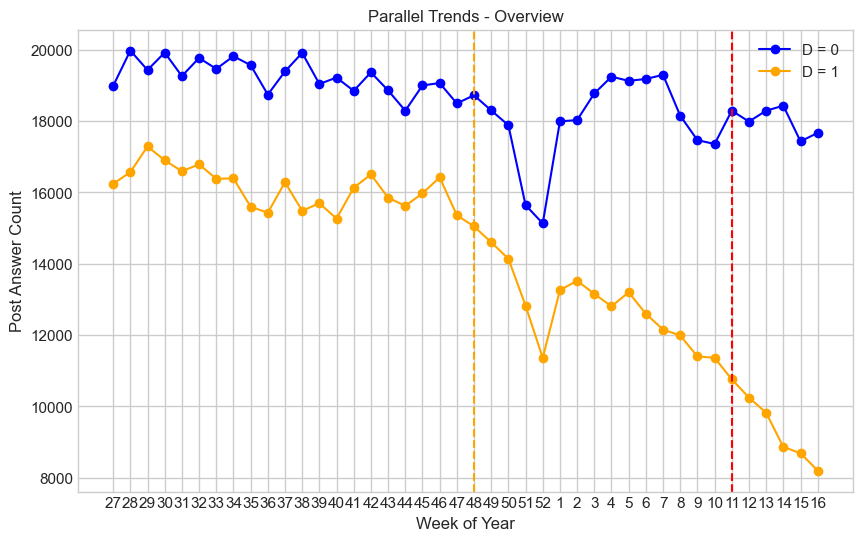

C:\Users\piotr\AppData\Local\Temp\ipykernel_21508\298455803.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Week_of_Year_{i}_D'] = df[f'Week_of_Year_{i}'] * df['D']
C:\Users\piotr\AppData\Local\Temp\ipykernel_21508\298455803.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Week_of_Year_{i}'] = np.where(df['Week_of_Year'] == i, 1, 0)
C:\Users\piotr\AppData\Local\Temp\ipykernel_21508\298455803.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

                          PanelOLS Estimation Summary                           
Dep. Variable:      Post_Answer_Count   R-squared:                        0.0660
Estimator:                   PanelOLS   R-squared (Between):              0.0000
No. Observations:               47208   R-squared (Within):               0.0800
Date:                Sat, May 27 2023   R-squared (Overall):              0.0052
Time:                        13:22:14   Log-likelihood                -2.003e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      80.305
Entities:                         562   P-value                           0.0000
Avg Obs:                       84.000   Distribution:                F(41,46564)
Min Obs:                       84.000                                           
Max Obs:                       84.000   F-statistic (robust):             4.2767
                            

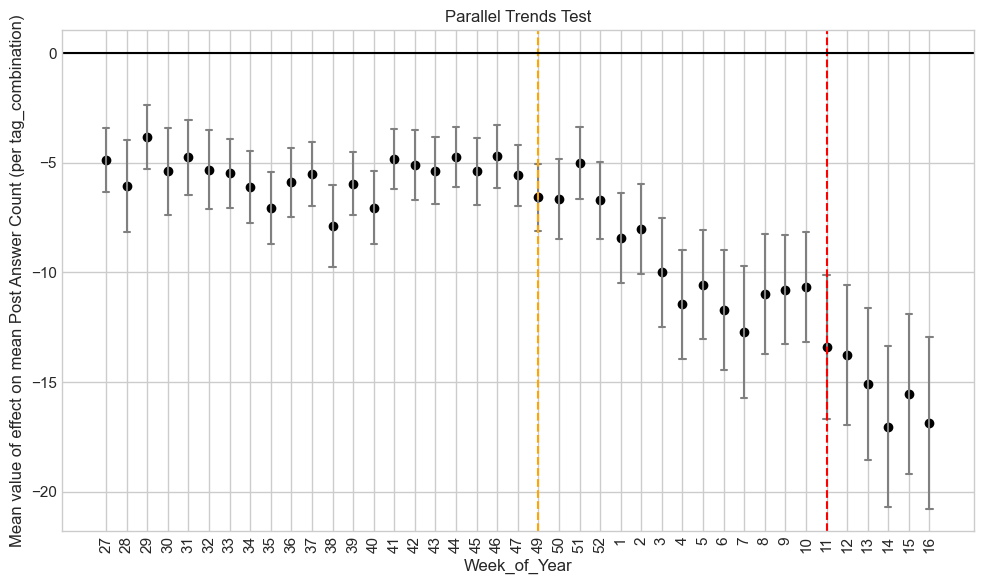

In [49]:
df = est_grouped_df_week_tag_reduced.copy()

# Create separate dataframes for D=0 and D=1
df_D0_PAC = df[df['D'] == 0]
df_D1_PAC = df[df['D'] == 1]

# Group by 'Week_of_Year' and calculate the sum 'Post_Count'
df_D0_grouped_PAC = df_D0_PAC.groupby('Week_of_Year')['Post_Answer_Count'].sum()
df_D1_grouped_PAC = df_D1_PAC.groupby('Week_of_Year')['Post_Answer_Count'].sum()

# Separate the weeks into two halves
first_half_D0_PAC = df_D0_grouped_PAC[df_D0_grouped_PAC.index >= 27]
second_half_D0_PAC = df_D0_grouped_PAC[df_D0_grouped_PAC.index < 27]
df_D0_grouped_PAC = pd.concat([first_half_D0_PAC, second_half_D0_PAC])

first_half_D1_PAC = df_D1_grouped_PAC[df_D1_grouped_PAC.index >= 27]
second_half_D1_PAC = df_D1_grouped_PAC[df_D1_grouped_PAC.index < 27]
df_D1_grouped_PAC = pd.concat([first_half_D1_PAC, second_half_D1_PAC])

# Create a new sequence of numbers for x-axis representing the actual order of weeks.
new_x = np.arange(1, len(df_D0_grouped_PAC) + 1)

# Plot the post counts for each group as lines with points
plt.figure(figsize=(10, 6))
plt.plot(new_x, df_D0_grouped_PAC.values, marker='o', color='blue', label='D = 0')
plt.plot(new_x, df_D1_grouped_PAC.values, marker='o', color='orange', label='D = 1')

# Add legend
plt.legend()

plt.title("Parallel Trends - Overview")
plt.xlabel("Week of Year")
plt.ylabel("Post Answer Count")
plt.grid(True)


# Add dashed orange line for week 49
plt.axvline(22, color='orange', linestyle='--')

# Add dashed red line for week 11
plt.axvline(37, color='red', linestyle='--')

# Show actual weeks on x-axis
plt.xticks(ticks=new_x, labels=df_D0_grouped.index)

plt.show()

#Drop Week_Number
df = df.drop(['Week_Number'], axis=1)


# Generate the dummy variables for the periods
for i in range(1, 53):
    if i != 0 and i != 48:  # Exclude Week_of_Year 48 (dummy trap)
        df[f'Week_of_Year_{i}'] = np.where(df['Week_of_Year'] == i, 1, 0)
        df[f'Week_of_Year_{i}_D'] = df[f'Week_of_Year_{i}'] * df['D']


# Set the index for the panel data
df = df.set_index(['tag_combined', 'Week_of_Year'])

# Create exogenous variables and add a constant
# Create exogenous variables and add a constant
exog_vars = [f'Week_of_Year_{i}_D' for i in range(1, 53) if i != 0 and i != 48]  # Exclude Week_of_Year == 48 (dummy trap)
exog = sm.add_constant(df[exog_vars])


# Run the regression
mod_PAC = PanelOLS(df.Post_Answer_Count, exog, entity_effects=True, check_rank=False, drop_absorbed=True, time_effects=True)
fe_res_PAC = mod_PAC.fit(cov_type='clustered', cluster_entity=True)



# Print the result
print(fe_res_PAC)

# Extract parameters and t-statistics from fe_res
params_PAC = fe_res_PAC.params[1:]  # Exclude constant
tvalues_PAC = fe_res_PAC.tstats[1:]  # Exclude constant

# Calculate standard errors: sqrt of variance
stderr_PAC = np.sqrt(np.diag(fe_res_PAC.cov))[1:]  # Exclude constant

# Calculate p-values
pvalues_PAC = fe_res_PAC.pvalues[1:]  # Exclude constant

# Create a new DataFrame from these values
results_df_PAC = pd.DataFrame({"params": params_PAC, "stderr": stderr_PAC, "tvalues": tvalues_PAC, "pvalues": pvalues_PAC})

# Add 'Week_of_Year' values as a column
# As per your input, these range from 1 to 16 and 27 to 47, 49 to 52
week_of_year_values = list(range(1, 17)) + list(range(27, 48)) + list(range(49, 53))
results_df_PAC["Week_of_Year"] = week_of_year_values

# Calculate lower and upper CI (assuming normal distribution)
results_df_PAC["lower_ci"] = results_df_PAC["params"] - 1.96*results_df_PAC["stderr"]
results_df_PAC["upper_ci"] = results_df_PAC["params"] + 1.96*results_df_PAC["stderr"]

# Create a custom order for 'Week_of_Year' - from 27 to 52, and then from 1 to 16
order = list(range(27, 48)) + list(range(49, 53)) + list(range(1, 17))

# Create a mapping of week numbers to new ordered indices
week_to_idx = {week: idx for idx, week in enumerate(order)}

# Map 'Week_of_Year' to the new ordered indices
results_df_PAC['Week_of_Year_Idx'] = results_df_PAC['Week_of_Year'].map(week_to_idx)

# Sort by the new index
results_df_PAC.sort_values("Week_of_Year_Idx", inplace=True)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the parameters as black scatter points
plt.scatter(results_df_PAC['Week_of_Year_Idx'], results_df_PAC['params'], color='black')

# Add vertical 'boxes' for each 'Week_of_Year'
for _, row in results_df_PAC.iterrows():
    plt.plot([row['Week_of_Year_Idx'], row['Week_of_Year_Idx']], [row['lower_ci'], row['upper_ci']], color="gray")

# Add short orthogonal lines at the top and bottom of each box
box_width = 0.3  # Adjust as needed
for _, row in results_df_PAC.iterrows():
    plt.plot([row['Week_of_Year_Idx'] - box_width/2, row['Week_of_Year_Idx'] + box_width/2], [row['lower_ci'], row['lower_ci']], color="gray")
    plt.plot([row['Week_of_Year_Idx'] - box_width/2, row['Week_of_Year_Idx'] + box_width/2], [row['upper_ci'], row['upper_ci']], color="gray")


# Add dashed orange line for week 49
plt.axvline(21, color='orange', linestyle='--')

# Add dashed red line for week 11
plt.axvline(35, color='red', linestyle='--')

# Add firm blue line for value 0 on y-axis
plt.axhline(0, color='black', linestyle='-')



# Adjust x-axis to display actual week numbers
plt.xticks(results_df_PAC['Week_of_Year_Idx'], results_df_PAC['Week_of_Year'], rotation='vertical')

plt.title("Parallel Trends Test")
plt.xlabel("Week_of_Year")
plt.ylabel("Mean value of effect on mean Post Answer Count (per tag_combination)")

plt.tight_layout()
plt.show()


## 8.1.5 Response_Scores	

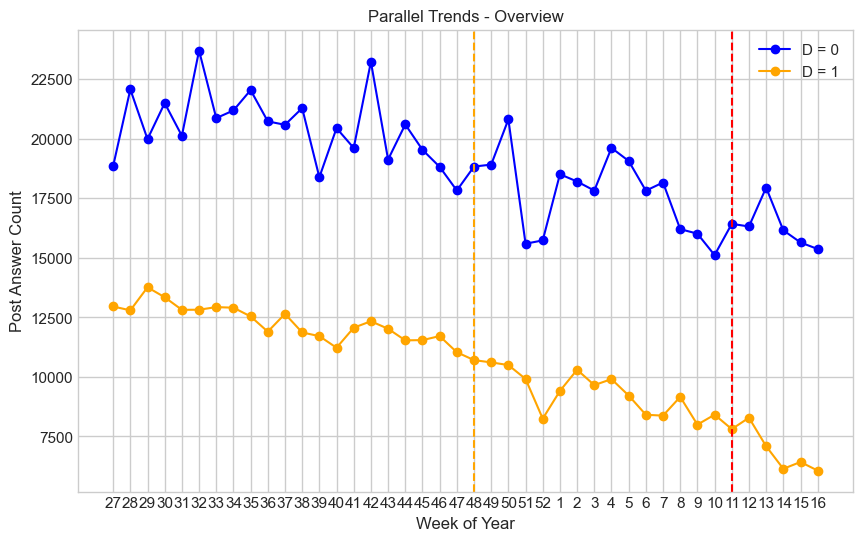

C:\Users\piotr\AppData\Local\Temp\ipykernel_21508\3920324855.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Week_of_Year_{i}_D'] = df[f'Week_of_Year_{i}'] * df['D']
C:\Users\piotr\AppData\Local\Temp\ipykernel_21508\3920324855.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Week_of_Year_{i}'] = np.where(df['Week_of_Year'] == i, 1, 0)
C:\Users\piotr\AppData\Local\Temp\ipykernel_21508\3920324855.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

                          PanelOLS Estimation Summary                           
Dep. Variable:        Response_Scores   R-squared:                        0.0355
Estimator:                   PanelOLS   R-squared (Between):              0.0000
No. Observations:               47208   R-squared (Within):               0.0332
Date:                Sat, May 27 2023   R-squared (Overall):              0.0114
Time:                        13:28:32   Log-likelihood                -2.401e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      41.825
Entities:                         562   P-value                           0.0000
Avg Obs:                       84.000   Distribution:                F(41,46564)
Min Obs:                       84.000                                           
Max Obs:                       84.000   F-statistic (robust):             4.5320
                            

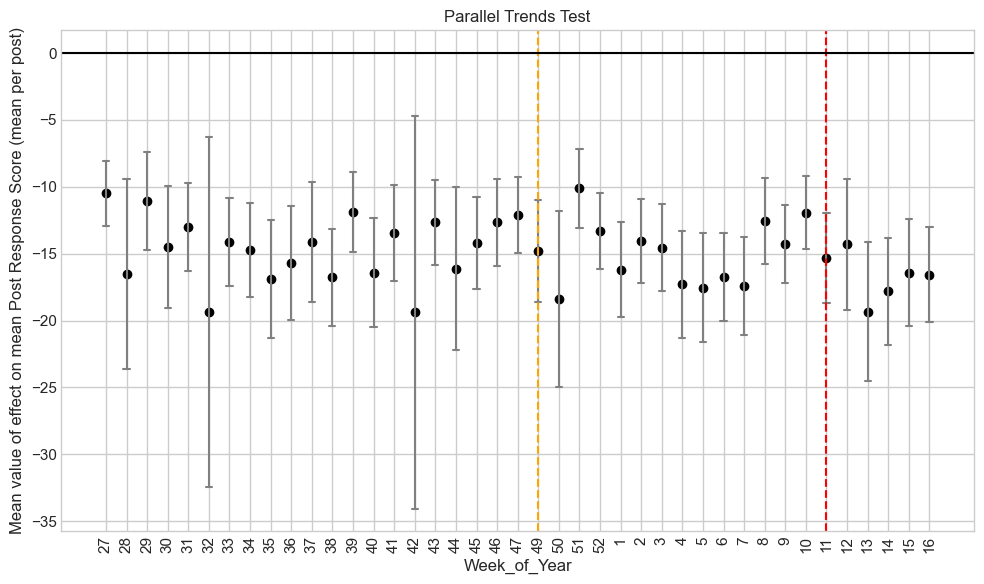

In [56]:
df = est_grouped_df_week_tag_reduced.copy()

# Create separate dataframes for D=0 and D=1
df_D0_RS = df[df['D'] == 0]
df_D1_RS = df[df['D'] == 1]

# Group by 'Week_of_Year' and calculate the sum 'Post_Count'
df_D0_grouped_RS = df_D0_RS.groupby('Week_of_Year')['Response_Scores'].sum()
df_D1_grouped_RS = df_D1_RS.groupby('Week_of_Year')['Response_Scores'].sum()

# Separate the weeks into two halves
first_half_D0_RS = df_D0_grouped_RS[df_D0_grouped_RS.index >= 27]
second_half_D0_RS = df_D0_grouped_RS[df_D0_grouped_RS.index < 27]
df_D0_grouped_RS = pd.concat([first_half_D0_RS, second_half_D0_RS])

first_half_D1_RS = df_D1_grouped_RS[df_D1_grouped_RS.index >= 27]
second_half_D1_RS = df_D1_grouped_RS[df_D1_grouped_RS.index < 27]
df_D1_grouped_RS = pd.concat([first_half_D1_RS, second_half_D1_RS])

# Create a new sequence of numbers for x-axis representing the actual order of weeks.
new_x = np.arange(1, len(df_D0_grouped_RS) + 1)

# Plot the post counts for each group as lines with points
plt.figure(figsize=(10, 6))
plt.plot(new_x, df_D0_grouped_RS.values, marker='o', color='blue', label='D = 0')
plt.plot(new_x, df_D1_grouped_RS.values, marker='o', color='orange', label='D = 1')

# Add legend
plt.legend()

plt.title("Parallel Trends - Overview")
plt.xlabel("Week of Year")
plt.ylabel("Post Answer Count")
plt.grid(True)


# Add dashed orange line for week 49
plt.axvline(22, color='orange', linestyle='--')

# Add dashed red line for week 11
plt.axvline(37, color='red', linestyle='--')

# Show actual weeks on x-axis
plt.xticks(ticks=new_x, labels=df_D0_grouped.index)

plt.show()

#Drop Week_Number
df = df.drop(['Week_Number'], axis=1)


# Generate the dummy variables for the periods
for i in range(1, 53):
    if i != 0 and i != 48:  # Exclude Week_of_Year 48 (dummy trap)
        df[f'Week_of_Year_{i}'] = np.where(df['Week_of_Year'] == i, 1, 0)
        df[f'Week_of_Year_{i}_D'] = df[f'Week_of_Year_{i}'] * df['D']


# Set the index for the panel data
df = df.set_index(['tag_combined', 'Week_of_Year'])

# Create exogenous variables and add a constant
# Create exogenous variables and add a constant
exog_vars = [f'Week_of_Year_{i}_D' for i in range(1, 53) if i != 0 and i != 48]  # Exclude Week_of_Year == 48 (dummy trap)
exog = sm.add_constant(df[exog_vars])


# Run the regression
mod_RS = PanelOLS(df.Response_Scores, exog, entity_effects=True, check_rank=False, drop_absorbed=True, time_effects=True)
fe_res_RS = mod_RS.fit(cov_type='clustered', cluster_entity=True)



# Print the result
print(fe_res_RS)

# Extract parameters and t-statistics from fe_res
params_RS = fe_res_RS.params[1:]  # Exclude constant
tvalues_RS = fe_res_RS.tstats[1:]  # Exclude constant

# Calculate standard errors: sqrt of variance
stderr_RS = np.sqrt(np.diag(fe_res_RS.cov))[1:]  # Exclude constant

# Calculate p-values
pvalues_RS = fe_res_RS.pvalues[1:]  # Exclude constant

# Create a new DataFrame from these values
results_df_RS = pd.DataFrame({"params": params_RS, "stderr": stderr_RS, "tvalues": tvalues_RS, "pvalues": pvalues_RS})

# Add 'Week_of_Year' values as a column
# As per your input, these range from 1 to 16 and 27 to 47, 49 to 52
week_of_year_values = list(range(1, 17)) + list(range(27, 48)) + list(range(49, 53))
results_df_RS["Week_of_Year"] = week_of_year_values

# Calculate lower and upper CI (assuming normal distribution)
results_df_RS["lower_ci"] = results_df_RS["params"] - 1.96*results_df_RS["stderr"]
results_df_RS["upper_ci"] = results_df_RS["params"] + 1.96*results_df_RS["stderr"]

# Create a custom order for 'Week_of_Year' - from 27 to 52, and then from 1 to 16
order = list(range(27, 48)) + list(range(49, 53)) + list(range(1, 17))

# Create a mapping of week numbers to new ordered indices
week_to_idx = {week: idx for idx, week in enumerate(order)}

# Map 'Week_of_Year' to the new ordered indices
results_df_RS['Week_of_Year_Idx'] = results_df_RS['Week_of_Year'].map(week_to_idx)

# Sort by the new index
results_df_RS.sort_values("Week_of_Year_Idx", inplace=True)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the parameters as black scatter points
plt.scatter(results_df_RS['Week_of_Year_Idx'], results_df_RS['params'], color='black')

# Add vertical 'boxes' for each 'Week_of_Year'
for _, row in results_df_RS.iterrows():
    plt.plot([row['Week_of_Year_Idx'], row['Week_of_Year_Idx']], [row['lower_ci'], row['upper_ci']], color="gray")

# Add short orthogonal lines at the top and bottom of each box
box_width = 0.3  # Adjust as needed
for _, row in results_df_RS.iterrows():
    plt.plot([row['Week_of_Year_Idx'] - box_width/2, row['Week_of_Year_Idx'] + box_width/2], [row['lower_ci'], row['lower_ci']], color="gray")
    plt.plot([row['Week_of_Year_Idx'] - box_width/2, row['Week_of_Year_Idx'] + box_width/2], [row['upper_ci'], row['upper_ci']], color="gray")


# Add dashed orange line for week 49
plt.axvline(21, color='orange', linestyle='--')

# Add dashed red line for week 11
plt.axvline(35, color='red', linestyle='--')

# Add firm blue line for value 0 on y-axis
plt.axhline(0, color='black', linestyle='-')



# Adjust x-axis to display actual week numbers
plt.xticks(results_df_RS['Week_of_Year_Idx'], results_df_RS['Week_of_Year'], rotation='vertical')

plt.title("Parallel Trends Test")
plt.xlabel("Week_of_Year")
plt.ylabel("Mean value of effect on mean Post Response Score (mean per post)")

plt.tight_layout()
plt.show()


## 8.1.6 Average Readability

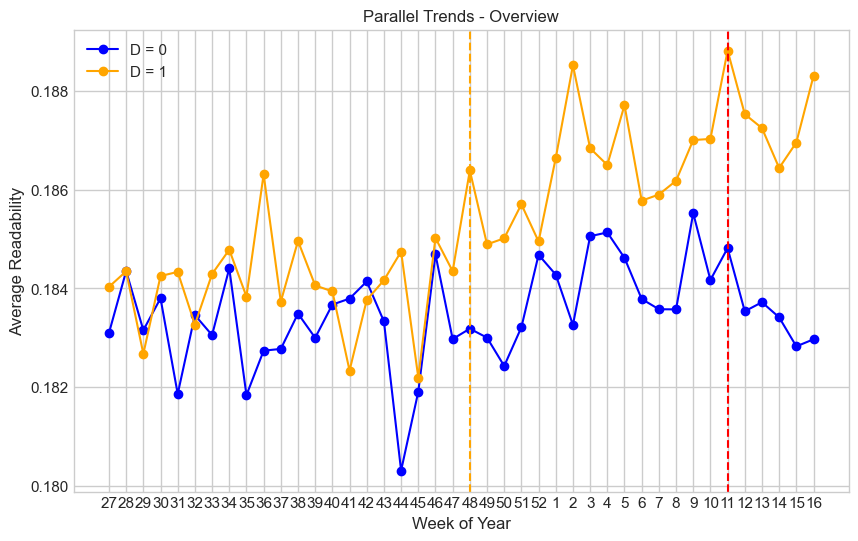

C:\Users\piotr\AppData\Local\Temp\ipykernel_21508\413534487.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Week_of_Year_{i}_D'] = df[f'Week_of_Year_{i}'] * df['D']
C:\Users\piotr\AppData\Local\Temp\ipykernel_21508\413534487.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Week_of_Year_{i}'] = np.where(df['Week_of_Year'] == i, 1, 0)
C:\Users\piotr\AppData\Local\Temp\ipykernel_21508\413534487.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

                          PanelOLS Estimation Summary                           
Dep. Variable:        avg_readability   R-squared:                        0.0039
Estimator:                   PanelOLS   R-squared (Between):              0.0000
No. Observations:               47208   R-squared (Within):               0.0044
Date:                Sat, May 27 2023   R-squared (Overall):              0.0023
Time:                        13:22:59   Log-likelihood                 1.192e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      4.4093
Entities:                         562   P-value                           0.0000
Avg Obs:                       84.000   Distribution:                F(41,46564)
Min Obs:                       84.000                                           
Max Obs:                       84.000   F-statistic (robust):             3.3847
                            

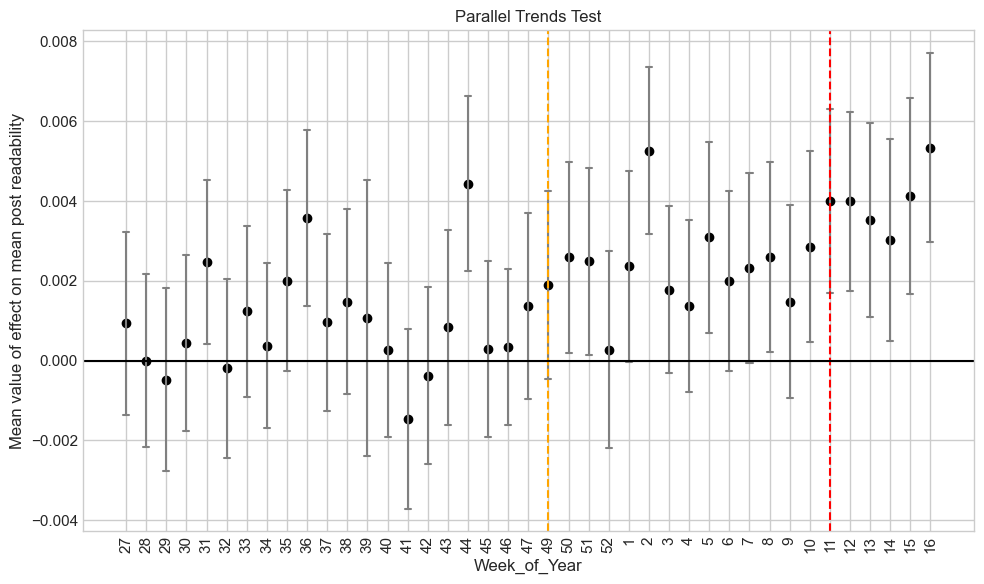

In [50]:
df = est_grouped_df_week_tag_reduced.copy()

# Create separate dataframes for D=0 and D=1
df_D0_READ = df[df['D'] == 0]
df_D1_READ = df[df['D'] == 1]

# Group by 'Week_of_Year' and calculate the sum 'Post_Count'
df_D0_grouped_READ = df_D0_READ.groupby('Week_of_Year')['avg_readability'].mean()
df_D1_grouped_READ = df_D1_READ.groupby('Week_of_Year')['avg_readability'].mean()

# Separate the weeks into two halves
first_half_D0_READ = df_D0_grouped_READ[df_D0_grouped_READ.index >= 27]
second_half_D0_READ = df_D0_grouped_READ[df_D0_grouped_READ.index < 27]
df_D0_grouped_READ = pd.concat([first_half_D0_READ, second_half_D0_READ])

first_half_D1_READ = df_D1_grouped_READ[df_D1_grouped_READ.index >= 27]
second_half_D1_READ = df_D1_grouped_READ[df_D1_grouped_READ.index < 27]
df_D1_grouped_READ = pd.concat([first_half_D1_READ, second_half_D1_READ])

# Create a new sequence of numbers for x-axis representing the actual order of weeks.
new_x = np.arange(1, len(df_D0_grouped_READ) + 1)

# Plot the post counts for each group as lines with points
plt.figure(figsize=(10, 6))
plt.plot(new_x, df_D0_grouped_READ.values, marker='o', color='blue', label='D = 0')
plt.plot(new_x, df_D1_grouped_READ.values, marker='o', color='orange', label='D = 1')

# Add legend
plt.legend()

plt.title("Parallel Trends - Overview")
plt.xlabel("Week of Year")
plt.ylabel("Average Readability")
plt.grid(True)


# Add dashed orange line for week 49
plt.axvline(22, color='orange', linestyle='--')

# Add dashed red line for week 11
plt.axvline(37, color='red', linestyle='--')

# Show actual weeks on x-axis
plt.xticks(ticks=new_x, labels=df_D0_grouped.index)

plt.show()

#Drop Week_Number
df = df.drop(['Week_Number'], axis=1)


# Generate the dummy variables for the periods
for i in range(1, 53):
    if i != 0 and i != 48:  # Exclude Week_of_Year 48 (dummy trap)
        df[f'Week_of_Year_{i}'] = np.where(df['Week_of_Year'] == i, 1, 0)
        df[f'Week_of_Year_{i}_D'] = df[f'Week_of_Year_{i}'] * df['D']


# Set the index for the panel data
df = df.set_index(['tag_combined', 'Week_of_Year'])

# Create exogenous variables and add a constant
# Create exogenous variables and add a constant
exog_vars = [f'Week_of_Year_{i}_D' for i in range(1, 53) if i != 0 and i != 48]  # Exclude Week_of_Year == 48 (dummy trap)
exog = sm.add_constant(df[exog_vars])


# Run the regression
mod_READ = PanelOLS(df.avg_readability, exog, entity_effects=True, check_rank=False, drop_absorbed=True, time_effects=True)
fe_res_READ = mod_READ.fit(cov_type='clustered', cluster_entity=True)



# Print the result
print(fe_res_READ)

# Extract parameters and t-statistics from fe_res
params_READ = fe_res_READ.params[1:]  # Exclude constant
tvalues_READ = fe_res_READ.tstats[1:]  # Exclude constant

# Calculate standard errors: sqrt of variance
stderr_READ = np.sqrt(np.diag(fe_res_READ.cov))[1:]  # Exclude constant

# Calculate p-values
pvalues_READ = fe_res_READ.pvalues[1:]  # Exclude constant

# Create a new DataFrame from these values
results_df_READ = pd.DataFrame({"params": params_READ, "stderr": stderr_READ, "tvalues": tvalues_READ, "pvalues": pvalues_READ})

# Add 'Week_of_Year' values as a column
# As per your input, these range from 1 to 16 and 27 to 47, 49 to 52
week_of_year_values = list(range(1, 17)) + list(range(27, 48)) + list(range(49, 53))
results_df_READ["Week_of_Year"] = week_of_year_values

# Calculate lower and upper CI (assuming normal distribution)
results_df_READ["lower_ci"] = results_df_READ["params"] - 1.96*results_df_READ["stderr"]
results_df_READ["upper_ci"] = results_df_READ["params"] + 1.96*results_df_READ["stderr"]

# Create a custom order for 'Week_of_Year' - from 27 to 52, and then from 1 to 16
order = list(range(27, 48)) + list(range(49, 53)) + list(range(1, 17))

# Create a mapping of week numbers to new ordered indices
week_to_idx = {week: idx for idx, week in enumerate(order)}

# Map 'Week_of_Year' to the new ordered indices
results_df_READ['Week_of_Year_Idx'] = results_df_READ['Week_of_Year'].map(week_to_idx)

# Sort by the new index
results_df_READ.sort_values("Week_of_Year_Idx", inplace=True)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the parameters as black scatter points
plt.scatter(results_df_READ['Week_of_Year_Idx'], results_df_READ['params'], color='black')

# Add vertical 'boxes' for each 'Week_of_Year'
for _, row in results_df_READ.iterrows():
    plt.plot([row['Week_of_Year_Idx'], row['Week_of_Year_Idx']], [row['lower_ci'], row['upper_ci']], color="gray")

# Add short orthogonal lines at the top and bottom of each box
box_width = 0.3  # Adjust as needed
for _, row in results_df_READ.iterrows():
    plt.plot([row['Week_of_Year_Idx'] - box_width/2, row['Week_of_Year_Idx'] + box_width/2], [row['lower_ci'], row['lower_ci']], color="gray")
    plt.plot([row['Week_of_Year_Idx'] - box_width/2, row['Week_of_Year_Idx'] + box_width/2], [row['upper_ci'], row['upper_ci']], color="gray")


# Add dashed orange line for week 49
plt.axvline(21, color='orange', linestyle='--')

# Add dashed red line for week 11
plt.axvline(35, color='red', linestyle='--')

# Add firm blue line for value 0 on y-axis
plt.axhline(0, color='black', linestyle='-')



# Adjust x-axis to display actual week numbers
plt.xticks(results_df_READ['Week_of_Year_Idx'], results_df_READ['Week_of_Year'], rotation='vertical')

plt.title("Parallel Trends Test")
plt.xlabel("Week_of_Year")
plt.ylabel("Mean value of effect on mean post readability")

plt.tight_layout()
plt.show()




# 8.2 DiD regressions - data aggregated at tag level

Only weekly level. Estimations for tag-reduced-week data frames

### Choose the data frame!

In [76]:
# Load the data
data = est_grouped_df_week_tag_reduced.copy() 
#Set the index for fixed effects
data = data.set_index(['tag_combined', 'Week_of_Year'])

Now we are ready for estimations! - choose control variables

In [77]:
# Add intercept to the independent variables

# Import relevant modules
from statsmodels.api import add_constant

X = add_constant(data[['DiD', 'D', 'T']])

X_Controls = add_constant(data[['DiD', 'D', 'T', 'Body_Length', 'Title_Length']])


### Correlation matrix of the controls

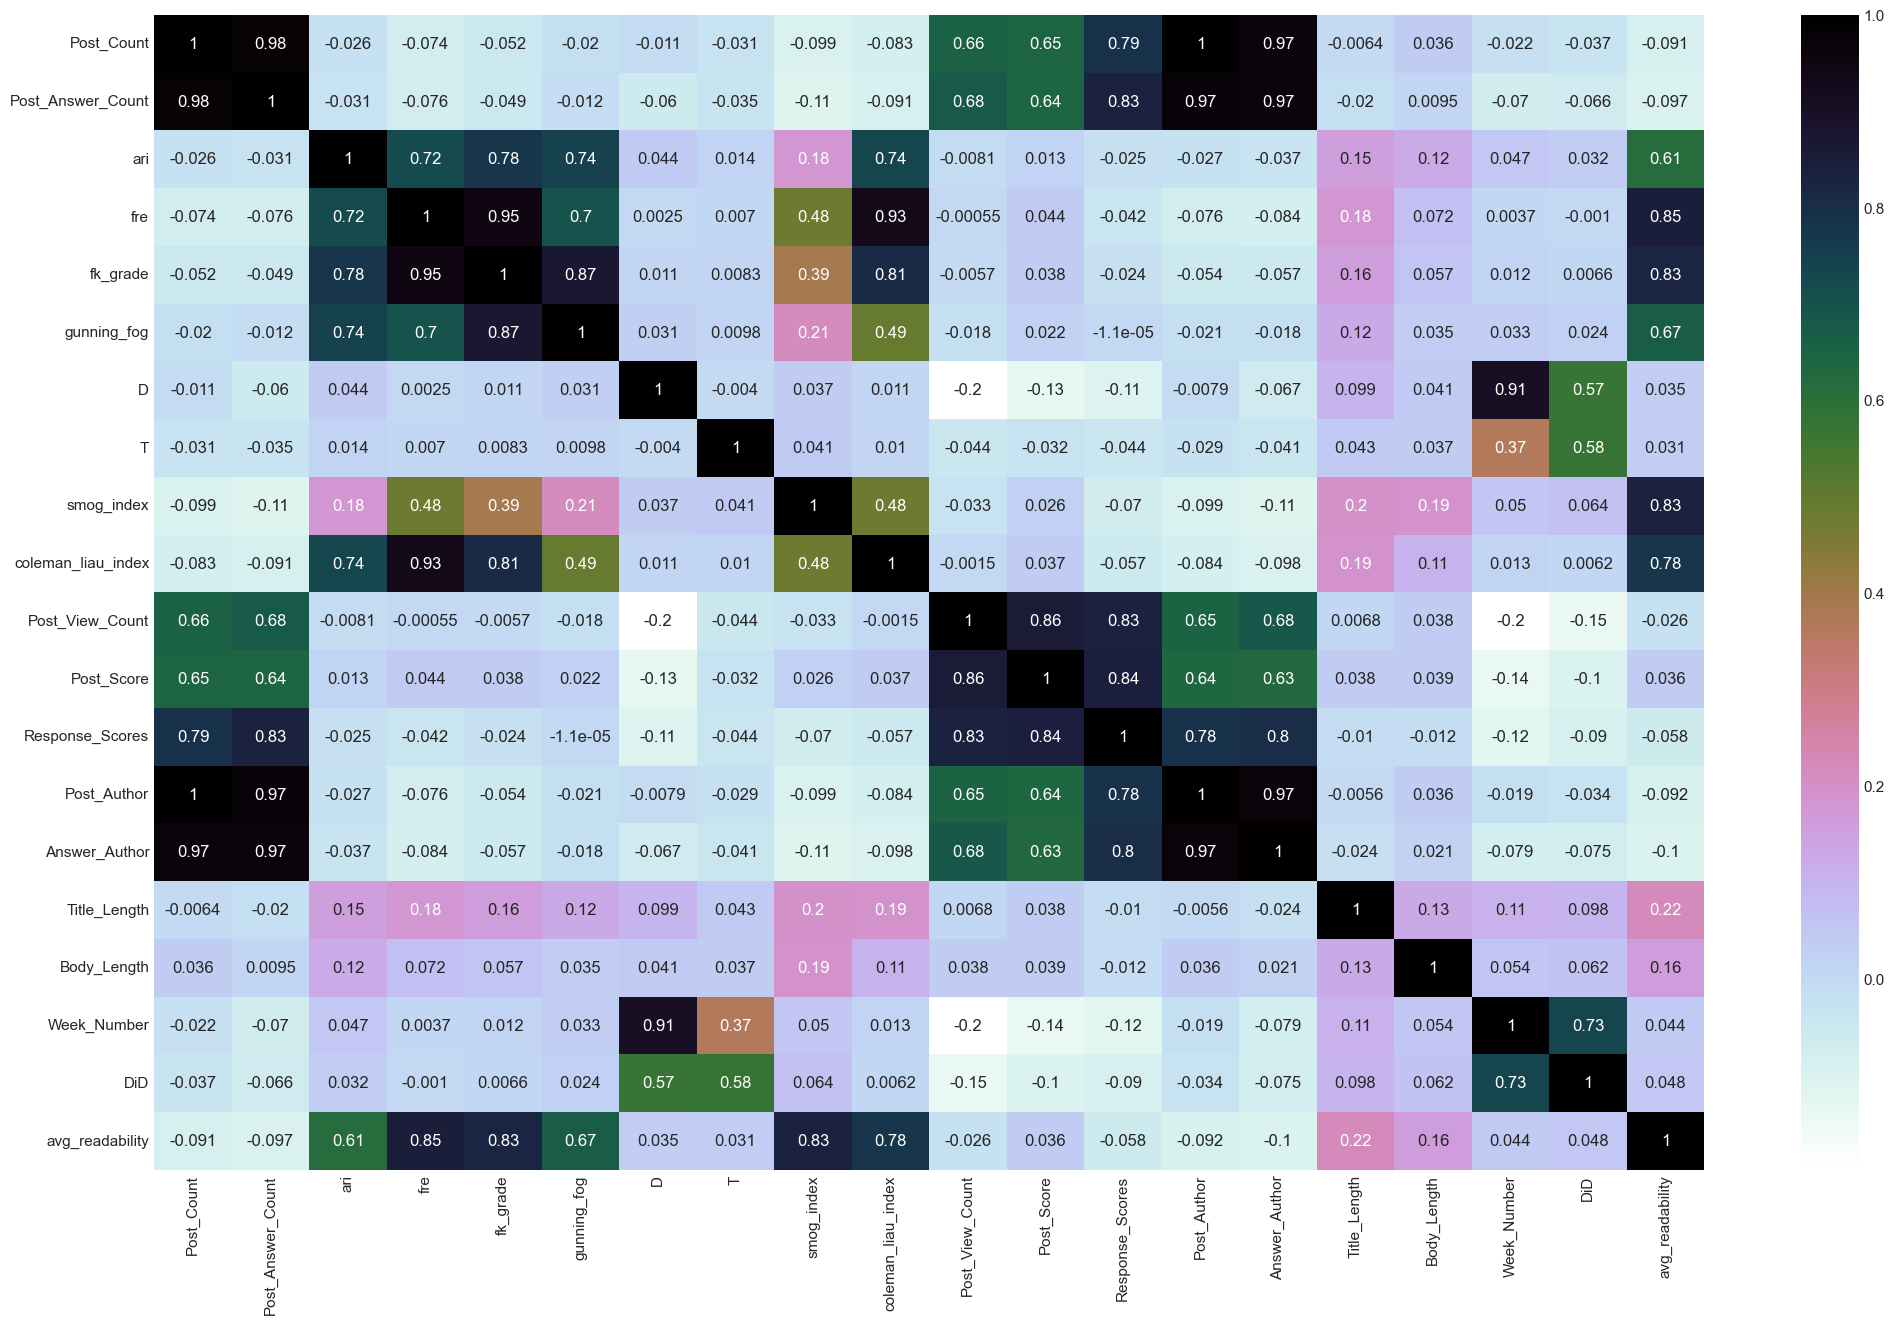

In [78]:
plt.figure(figsize=(25,15)) 
sns.heatmap(data.corr(),annot=True,cmap='cubehelix_r')
plt.show()

### 8.2.1 Post Count

In [57]:
# Regression - FX for Forum/Tag_combined and FX for Weeks
FE_PC_FE_T = PanelOLS(data.Post_Count, X,
              entity_effects = True,
              time_effects=True)
              
# Result
result_PC_FE_T = FE_PC_FE_T.fit(cov_type = 'clustered',
              cluster_entity=True,
            #   cluster_time=True
            )

# Regression - FX for Forum/Tag_combined and FX for Weeks + controls
FE_PC_FE_T_controls  = PanelOLS(data.Post_Count, X_Controls,
              entity_effects = True,
              time_effects=True
              )
              
# Result
result_PC_FE_T_controls = FE_PC_FE_T_controls.fit(cov_type = 'clustered',
              cluster_entity=True,
            #   cluster_time=True
             )

# Results
print(result_PC_FE_T)
print(result_PC_FE_T_controls)

# Regression - null model, no FX

Poisson_model_PC = sm.GLM(data.Post_Count, X, family=sm.families.Poisson())
result_Poisson_PC = Poisson_model_PC.fit(cov_type='HC0')

Poisson_model_PC_controls = sm.GLM(data.Post_Count, X_Controls, family=sm.families.Poisson())
result_Poisson_PC_controls = Poisson_model_PC_controls.fit(cov_type='HC0')

print(result_Poisson_PC.summary())
print(result_Poisson_PC_controls.summary())


#fepois - R package

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.stats.diagnostic import het_breuschpagan

# Subset the DataFrame to only include predictor variables
df_predictors = X_Controls

# Add a constant term to your DataFrame. This is necessary for calculating VIF
df_predictors = add_constant(df_predictors)

# Calculate the VIF for each predictor variable
vif = pd.DataFrame()
vif["Variable"] = df_predictors.columns
vif["VIF"] = [variance_inflation_factor(df_predictors.values, i) for i in range(df_predictors.shape[1])]

print(vif)

                          PanelOLS Estimation Summary                           
Dep. Variable:             Post_Count   R-squared:                        0.0173
Estimator:                   PanelOLS   R-squared (Between):          -1.127e-05
No. Observations:               47208   R-squared (Within):               0.0414
Date:                Sat, May 27 2023   R-squared (Overall):              0.0015
Time:                        13:29:10   Log-likelihood                -1.794e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      272.85
Entities:                         562   P-value                           0.0000
Avg Obs:                       84.000   Distribution:                 F(3,46602)
Min Obs:                       84.000                                           
Max Obs:                       84.000   F-statistic (robust):             18.439
                            

### 8.2.2 Post View Count

In [80]:
# Import the packages
import pandas as pd
from linearmodels import PanelOLS
import numpy as np


# Regression - FX for Forum/Tag_combined and FX for Weeks
FE_PVC_FE_T = PanelOLS(data.Post_View_Count, X,
              entity_effects = True,
              time_effects=True)
              
# Result
result_PVC_FE_T = FE_PVC_FE_T.fit(cov_type = 'clustered',
              cluster_entity=True,
            #   cluster_time=True
            )



# # Regression - FX for Forum/Tag_combined and FX for Weeks + contorls
FE_PVC_FE_T_controls  = PanelOLS(data.Post_View_Count, X_Controls,
              entity_effects = True,
              time_effects=True
              )
              
# Result
result_PVC_FE_T_controls = FE_PVC_FE_T_controls.fit(cov_type = 'clustered',
              cluster_entity=True,
            #   cluster_time=True
             )

#Results
print(result_PVC_FE_T)
print(result_PVC_FE_T_controls)

# Regression - null model, no FX

Poisson_model_PVC = sm.GLM(data.Post_View_Count, X, family=sm.families.Poisson())
result_Poisson_PVC = Poisson_model_PVC.fit(cov_type='HC0')

Poisson_model_PVC_controls = sm.GLM(data.Post_View_Count, X_Controls, family=sm.families.Poisson())
result_Poisson_PVC_controls = Poisson_model_PVC_controls.fit(cov_type='HC0')

print(result_Poisson_PVC.summary())
print(result_Poisson_PVC_controls.summary())


                          PanelOLS Estimation Summary                           
Dep. Variable:        Post_View_Count   R-squared:                        0.0785
Estimator:                   PanelOLS   R-squared (Between):          -4.076e-06
No. Observations:               47208   R-squared (Within):               0.0789
Date:                Sat, May 27 2023   R-squared (Overall):              0.0388
Time:                        14:00:11   Log-likelihood                 -5.36e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1323.7
Entities:                         562   P-value                           0.0000
Avg Obs:                       84.000   Distribution:                 F(3,46602)
Min Obs:                       84.000                                           
Max Obs:                       84.000   F-statistic (robust):             35.793
                            

### 8.2.3 Post_Score

In [82]:
# Import the packages
import pandas as pd
from linearmodels import PanelOLS
import numpy as np


# Regression - FX for Forum/Tag_combined and FX for Weeks
FE_PS_FE_T = PanelOLS(data.Post_Score, X,
              entity_effects = True,
              time_effects=True)
              
# Result
result_PS_FE_T = FE_PS_FE_T.fit(cov_type = 'clustered',
              cluster_entity=True,
            #   cluster_time=True
            )



# # Regression - FX for Forum/Tag_combined and FX for Weeks + contorls
FE_PS_FE_T_controls  = PanelOLS(data.Post_Score, X_Controls,
              entity_effects = True,
              time_effects=True
              )
              
# Result
result_PS_FE_T_controls = FE_PS_FE_T_controls.fit(cov_type = 'clustered',
              cluster_entity=True,
            #   cluster_time=True
             )

#Results
print(result_PS_FE_T)
print(result_PS_FE_T_controls)

# Regression - null model, no FX

Poisson_model_PS = sm.GLM(data.Post_Score, X, family=sm.families.Poisson())
result_Poisson_PS = Poisson_model_PS.fit(cov_type='HC0')

Poisson_model_PS_controls = sm.GLM(data.Post_Score, X_Controls, family=sm.families.Poisson())
result_Poisson_PS_controls = Poisson_model_PS_controls.fit(cov_type='HC0')

print(result_Poisson_PS.summary())
print(result_Poisson_PS_controls.summary())


                          PanelOLS Estimation Summary                           
Dep. Variable:             Post_Score   R-squared:                        0.0488
Estimator:                   PanelOLS   R-squared (Between):          -5.404e-06
No. Observations:               47208   R-squared (Within):               0.0403
Date:                Sat, May 27 2023   R-squared (Overall):              0.0151
Time:                        14:01:25   Log-likelihood                -2.033e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      797.26
Entities:                         562   P-value                           0.0000
Avg Obs:                       84.000   Distribution:                 F(3,46602)
Min Obs:                       84.000                                           
Max Obs:                       84.000   F-statistic (robust):             38.623
                            

c:\Users\piotr\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1767: RuntimeWarning: invalid value encountered in double_scalars
  prsq = 1 - np.exp((self.llnull - self.llf) * (2 / self.nobs))
c:\Users\piotr\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1767: RuntimeWarning: invalid value encountered in double_scalars
  prsq = 1 - np.exp((self.llnull - self.llf) * (2 / self.nobs))


### 8.2.4 Post Answer Count

In [58]:
# Import the packages
import pandas as pd
from linearmodels import PanelOLS
import numpy as np


# Regression - FX for Forum/Tag_combined and FX for Weeks
FE_PAC_FE_T = PanelOLS(data.Post_Answer_Count, X,
              entity_effects = True,
              time_effects=True)
              
# Result
result_PAC_FE_T = FE_PAC_FE_T.fit(cov_type = 'clustered',
              cluster_entity=True,
            #   cluster_time=True
            )



# # Regression - FX for Forum/Tag_combined and FX for Weeks + contorls
FE_PAC_FE_T_controls  = PanelOLS(data.Post_Answer_Count, X_Controls,
              entity_effects = True,
              time_effects=True
              )
              
# Result
result_PAC_FE_T_controls = FE_PAC_FE_T_controls.fit(cov_type = 'clustered',
              cluster_entity=True,
            #   cluster_time=True
             )

#Results
print(result_PAC_FE_T)
print(result_PAC_FE_T_controls)

# Regression - null model, no FX

Poisson_model_PAC = sm.GLM(data.Post_Answer_Count, X, family=sm.families.Poisson())
result_Poisson_PAC = Poisson_model_PAC.fit(cov_type='HC0')

Poisson_model_PAC_controls = sm.GLM(data.Post_Answer_Count, X_Controls, family=sm.families.Poisson())
result_Poisson_PAC_controls = Poisson_model_PAC_controls.fit(cov_type='HC0')

print(result_Poisson_PAC.summary())
print(result_Poisson_PAC_controls.summary())

                          PanelOLS Estimation Summary                           
Dep. Variable:      Post_Answer_Count   R-squared:                        0.0618
Estimator:                   PanelOLS   R-squared (Between):          -5.578e-06
No. Observations:               47208   R-squared (Within):               0.0688
Date:                Sat, May 27 2023   R-squared (Overall):              0.0045
Time:                        13:29:58   Log-likelihood                -2.004e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1024.1
Entities:                         562   P-value                           0.0000
Avg Obs:                       84.000   Distribution:                 F(3,46602)
Min Obs:                       84.000                                           
Max Obs:                       84.000   F-statistic (robust):             30.573
                            

### 8.2.5 Response_Scores

In [84]:
# Import the packages
import pandas as pd
from linearmodels import PanelOLS
import numpy as np


# Regression - FX for Forum/Tag_combined and FX for Weeks
FE_RS_FE_T = PanelOLS(data.Response_Scores, X,
              entity_effects = True,
              time_effects=True)
              
# Result
result_RS_FE_T = FE_RS_FE_T.fit(cov_type = 'clustered',
              cluster_entity=True,
            #   cluster_time=True
            )



# # Regression - FX for Forum/Tag_combined and FX for Weeks + contorls
FE_RS_FE_T_controls  = PanelOLS(data.Response_Scores, X_Controls,
              entity_effects = True,
              time_effects=True
              )
              
# Result
result_RS_FE_T_controls = FE_RS_FE_T_controls.fit(cov_type = 'clustered',
              cluster_entity=True,
            #   cluster_time=True
             )

#Results
print(result_RS_FE_T)
print(result_RS_FE_T_controls)

# Regression - Poisson, no FX

Poisson_model_RS = sm.GLM(data.Response_Scores, X, family=sm.families.Poisson())
result_Poisson_RS = Poisson_model_RS.fit(cov_type='HC0')

Poisson_model_RS_controls = sm.GLM(data.Response_Scores, X_Controls, family=sm.families.Poisson())
result_Poisson_RS_controls = Poisson_model_RS_controls.fit(cov_type='HC0')

print(result_Poisson_RS.summary())
print(result_Poisson_RS_controls.summary())


                          PanelOLS Estimation Summary                           
Dep. Variable:        Response_Scores   R-squared:                        0.0355
Estimator:                   PanelOLS   R-squared (Between):           3.297e-06
No. Observations:               47208   R-squared (Within):               0.0322
Date:                Sat, May 27 2023   R-squared (Overall):              0.0110
Time:                        14:03:34   Log-likelihood                -2.401e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      571.00
Entities:                         562   P-value                           0.0000
Avg Obs:                       84.000   Distribution:                 F(3,46602)
Min Obs:                       84.000                                           
Max Obs:                       84.000   F-statistic (robust):             38.941
                            

c:\Users\piotr\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1767: RuntimeWarning: invalid value encountered in double_scalars
  prsq = 1 - np.exp((self.llnull - self.llf) * (2 / self.nobs))
c:\Users\piotr\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1767: RuntimeWarning: invalid value encountered in double_scalars
  prsq = 1 - np.exp((self.llnull - self.llf) * (2 / self.nobs))


### 8.2.6 Readability metrics

In [85]:
# Import the packages
import pandas as pd
from linearmodels import PanelOLS
import numpy as np

# Regression - FX for Forum/Tag_combined and FX for Weeks
FE_READ_FE_T = PanelOLS(data.avg_readability, X,
              entity_effects = True,
              time_effects=True)
              
# Result
result_READ_FE_T = FE_READ_FE_T.fit(cov_type = 'clustered',
              cluster_entity=True,
            #   cluster_time=True
            )


# # Regression - FX for Forum/Tag_combined and FX for Weeks + contorls
FE_READ_FE_T_controls  = PanelOLS(data.avg_readability, X_Controls,
              entity_effects = True,
              time_effects=True
              )
              
# Result
result_READ_FE_T_controls = FE_READ_FE_T_controls.fit(cov_type = 'clustered',
              cluster_entity=True,
            #   cluster_time=True
             )

#Results
print(result_READ_FE_T)
print(result_READ_FE_T_controls)


# Regression - Poisson, no FX

Poisson_model_READ = sm.GLM(data.avg_readability, X, family=sm.families.Poisson())
result_Poisson_READ = Poisson_model_READ.fit(cov_type='HC0')

Poisson_model_READ_controls = sm.GLM(data.avg_readability, X_Controls, family=sm.families.Poisson())
result_Poisson_READ_controls = Poisson_model_READ_controls.fit(cov_type='HC0')

print(result_Poisson_READ.summary())
print(result_Poisson_READ_controls.summary())


                          PanelOLS Estimation Summary                           
Dep. Variable:        avg_readability   R-squared:                        0.0030
Estimator:                   PanelOLS   R-squared (Between):             -0.0002
No. Observations:               47208   R-squared (Within):              -0.0071
Date:                Sat, May 27 2023   R-squared (Overall):             -0.0038
Time:                        14:05:05   Log-likelihood                 1.192e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      46.991
Entities:                         562   P-value                           0.0000
Avg Obs:                       84.000   Distribution:                 F(3,46602)
Min Obs:                       84.000                                           
Max Obs:                       84.000   F-statistic (robust):             25.968
                            

### 8.2.7 Content Novelty

Drop rows with no values of either cos_sim_D0 or cos_sim_D1. Then merge the values into one column and calculate DiD.

In [86]:
final_result_df_tfidf = pd.read_csv('Master Thesis Data\\final_result_df_tfidf.csv')
final_result_df_lsi = pd.read_csv('Master Thesis Data\\final_result_df_lsi.csv')
final_result_df_doc2vec = pd.read_csv('Master Thesis Data\\final_result_df_doc2vec.csv')

In [87]:
#Drop rows of this data frames without cos_sim_D0 or cos_sim_D1 values
final_result_df_tfidf = final_result_df_tfidf.dropna(subset=['cos_sim_D0', 'cos_sim_D1'], how='all')
final_result_df_lsi = final_result_df_lsi.dropna(subset=['cos_sim_D0_lsi', 'cos_sim_D1_lsi'], how='all')
final_result_df_doc2vec = final_result_df_doc2vec.dropna(subset=['cos_sim_D0_doc2vec', 'cos_sim_D1_doc2vec'], how='all')


In [88]:
print(final_result_df_tfidf['cos_sim_D0'].isna().sum())
print(final_result_df_tfidf['cos_sim_D1'].isna().sum())
print(final_result_df_lsi['cos_sim_D0_lsi'].isna().sum())
print(final_result_df_lsi['cos_sim_D1_lsi'].isna().sum())
print(final_result_df_doc2vec['cos_sim_D0_doc2vec'].isna().sum())
print(final_result_df_doc2vec['cos_sim_D1_doc2vec'].isna().sum())

1300
1300
1300
1300
1300
1300


In [89]:
final_result_df_tfidf['cos_sim'] = final_result_df_tfidf['cos_sim_D0'].fillna(final_result_df_tfidf['cos_sim_D1'])
final_result_df_lsi['cos_sim'] = final_result_df_lsi['cos_sim_D0_lsi'].fillna(final_result_df_lsi['cos_sim_D1_lsi'])
final_result_df_doc2vec['cos_sim'] = final_result_df_doc2vec['cos_sim_D0_doc2vec'].fillna(final_result_df_doc2vec['cos_sim_D1_doc2vec'])

In [90]:
#Chech NA count in final_result_df_tfidf['cos_sim']
print(final_result_df_tfidf['cos_sim'].isna().sum())
print(final_result_df_lsi['cos_sim'].isna().sum())
print(final_result_df_doc2vec['cos_sim'].isna().sum())

0
0
0


In [91]:
#Drop 'cos_sim_D0' and 'cos_sim_D1' columns
final_result_df_tfidf = final_result_df_tfidf.drop(['cos_sim_D0', 'cos_sim_D1'], axis=1)
final_result_df_lsi = final_result_df_lsi.drop(['cos_sim_D0_lsi', 'cos_sim_D1_lsi'], axis=1)
final_result_df_doc2vec = final_result_df_doc2vec.drop(['cos_sim_D0_doc2vec', 'cos_sim_D1_doc2vec'], axis=1)

#### Simple Did regressions

In [92]:
#Create interaction term
final_result_df_tfidf['DiD'] = final_result_df_tfidf['D'] * final_result_df_tfidf['T']
final_result_df_lsi['DiD'] = final_result_df_lsi['D'] * final_result_df_lsi['T']
final_result_df_doc2vec['DiD'] = final_result_df_doc2vec['D'] * final_result_df_doc2vec['T']

In [93]:
final_result_df_tfidf

,Post_Creation_Date,Post_View_Count,Post_Title,Post_Score,Post_Answer_Count,Response_Scores,Post_Author,Answer_Author,Forum,Week_of_Year,...,T,Title_Length,Body_Length,Body,count1,count2,count3,count4,cos_sim,DiD
95,2022-04-20 11:46:51,194,Can I define a method of interface type inside...,0,1,1,9090128,0,Stack Overflow,16,...,1,54,299,<pre><code>abstract class someClass\n{\n pu...,95.0,110.0,121.0,121.0,0.053782,0
96,2022-03-16 19:57:08,278,Sort and filter with varying key .net,1,2,2,0,9665021,Stack Overflow,11,...,1,37,680,<p>I have a table in the frontend with multipl...,95.0,110.0,121.0,121.0,0.034316,0
97,2022-01-31 16:08:21,330,Packing the Project didn't create nupkg file (...,0,2,3,14382247,0,Stack Overflow,5,...,1,65,1659,"<p>I followed this guide: <a href=""https://lea...",95.0,110.0,121.0,121.0,0.047094,0
98,2022-01-19 08:38:26,176,C# + .NET : Find the path of an app like chrom...,0,1,1,17014796,0,Stack Overflow,3,...,1,96,577,<p>the best that i have found about my problem...,95.0,110.0,121.0,121.0,0.076700,0
99,2021-12-17 12:10:38,450,AzureKeyVaultConfigurationProvider Cancellatio...,1,1,1,169674,2501279,Stack Overflow,50,...,1,76,1924,<p>I'm currently using <code>IConfigurationBui...,95.0,110.0,121.0,121.0,0.062409,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11459,2023-03-26 13:02:15,60,SQL min and max function not displaying proper...,-2,2,1,21494163,4286884,Stack Overflow,12,...,1,54,594,<p>I am having a problem with using the MIN an...,91.0,69.0,71.0,61.0,0.072648,1
11460,2023-03-24 20:58:21,56,Select values with Condition,0,4,1,838893,0,Stack Overflow,12,...,1,28,1699,"<p>I have a table with this sample data, where...",91.0,69.0,71.0,61.0,0.048503,1
11461,2023-01-10 07:26:38,76,SQL smart search possible?,0,1,0,20945834,0,Stack Overflow,2,...,1,26,2949,<p>I am trying to pull a list from a large rep...,91.0,69.0,71.0,61.0,0.063104,1
11462,2023-03-05 15:03:37,56,SQL SERVER FIND ROWS that dont have values in ...,0,3,5,17128590,18562668,Stack Overflow,9,...,1,59,2448,<p>i have 3 tables with one to many relation\n...,91.0,69.0,71.0,61.0,0.017567,1


In [94]:
final_result_df_tfidf.reset_index(drop=True, inplace=True)
final_result_df_lsi.reset_index(drop=True, inplace=True)
final_result_df_doc2vec.reset_index(drop=True, inplace=True)

In the content novelty estimations we only include D, as the scores are pairwise cosine similarity values 

In [99]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.formula.api import glm

model_tfidf = ols('cos_sim ~ D', data=final_result_df_tfidf).fit()
model_lsi = ols('cos_sim ~ D', data=final_result_df_lsi).fit()
model_doc2vec = ols('cos_sim ~ D', data=final_result_df_doc2vec).fit()

print(model_tfidf.summary())
print(model_lsi.summary())
print(model_doc2vec.summary())


                            OLS Regression Results                            
Dep. Variable:                cos_sim   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.05428
Date:                Sat, 27 May 2023   Prob (F-statistic):              0.816
Time:                        14:08:55   Log-Likelihood:                 6491.6
No. Observations:                2600   AIC:                        -1.298e+04
Df Residuals:                    2598   BIC:                        -1.297e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0467      0.001     84.520      0.0